# Introduction to Google Cloud Platform and Infractructure as a code

Google Cloud Platform (GCP) is a cloud platform that allows you to build, test and deploy your solutions using Google’s reliable and scalable infrastructure. GCP runs on the same infrastructure that Google uses internally for its products such as Google Search and YouTube.

Similar platforms: Amazon AWS, Microsoft Azure.

## Redeeming Education Cloud Credits

You should have already received email about it, but in case you still haven't redeem your credits please do it now.

## Cloud setup

To create an account enter [Google Cloud Console](https://console.cloud.google.com/welcome). Use the same email adress as you used to redeem your credits. Note that you should create a google account on this email address first if one is not created already. After creating an account create a new project in `uw.edu.pl` organization. After finishing you should enter the project page similar to the following:
<center><img src='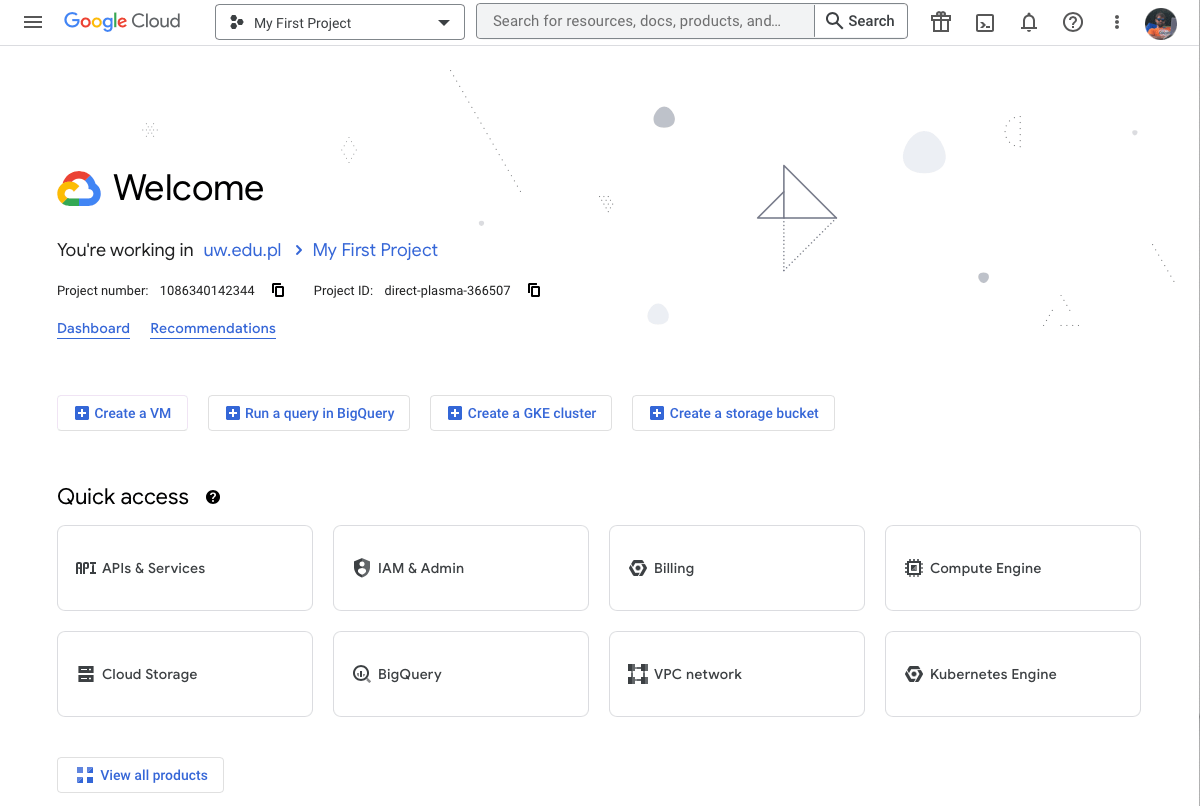
'></center>

This scenario will be refering to the English language version of the cloud UI. If your default version is in another language, then to easier go through this scenario, we advise to change it:
```
Three dots (top right corner) -> Preferences -> Language: English (United States)
```

**IMPORTANT**: Enable compute engine
```
Hamburger (☰) -> Compute Engine
Click enable
```

### Create instances

**Remember to stop created instances after finishing the lab. Running instances drain your free resources and, if you connected your credit card to the cloud, it may result in billing you. We discourage you to connecting the card, and if you already had connected one its best to remove it.**

```
Hamburger (☰) -> Compute Engine -> VM Instances
(...) -> 'Create Instance'
```



Yo should now see the following screen:

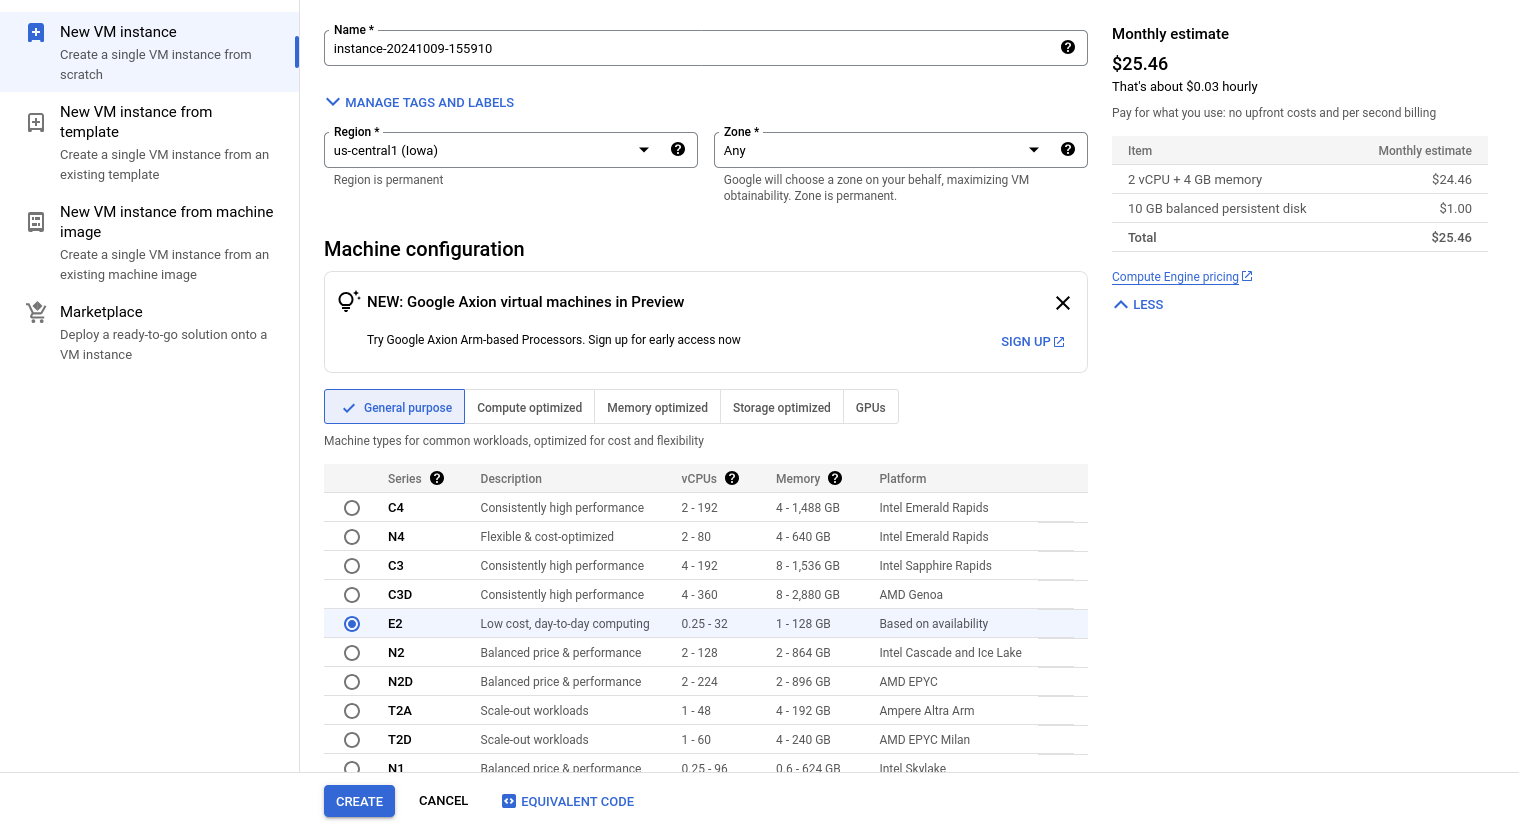


Let us do a quick overview of selected options you can see here:

### Region and zone

This will affect delays when communicating with your VMs as well as their price - for the lab you can stay with default one, as it is one of the cheapest ones (in Europe also Belgium is quite cheap).

### Machine configuration

This is most important step. There is a lot of machine types divided into several tabs. There are several informations about each machine type. As you see there are ranges in the vCPU and Memory columns: When you choose the Series, you can specify below the precise type of machine. The type you can select from several presets with varying vCPU to memory ratio or specify your own custom type (for an additional fee).

As you see some configurations may have < 1 vCPU. It means that those VMs will be collocated with other VMs on the same physical core, and the scheduler will ensure that they will get at least the specified percentage of a single virtual core. For example if you will configure the E2-small instance, then it will get at least 50% of time of a single virtual core. It is also described that such an instance will get one physical core, which contains 2 virtual cores. So if you are lucky you can run two threads on full performance on such VM, but if the load in the cloud would rise, then the performance will dwindle.

You can also rent a VM with GPU (see the tab GPUs) or TPU - Google's proprietary hardware, that should be more cost effective for machine learning than GPUs. To rent a TPU you need to perform additional [setup (enable another API_](https://cloud.google.com/tpu/docs/setup-gcp-account). We won't be renting any of those in this classes, as the costs would quickly eat all your credits.

### Availability policies

You can choose here to rent a Spot machine. Such machines are much cheaper, but can be terminated by the scheduler at any point. There may be cost effective for running some failure resistant jobs, e.g. data mining, but definitely not for training.

### Identity and API access

GCP is designed to be used by large institutions that need to have complex structure of user access levels. For this reason it offers flexible and multi-tier system of accounts, roles, resources and privileges.

From this menu you can choose a service account that will be used to run the code in the cloud. This setting can both control which users can access the VM as well as what privileges the code executed on this VM has. TODO: make sure this is true.

For now selecting here the default account is fine, but in general this is considered unsafe, as the default account has very wide array of privileges.

There are also several other options that we won't cover in this scenario, but you are encouraged to explore them yourself - most are pretty self explaining.


### Testing GCP

Rent two `e2-small` VMs. Name them as `vm1` and `vm2`. Leave defaults in the remaining options. You should now see a screen looking like (note that the zone could be different):

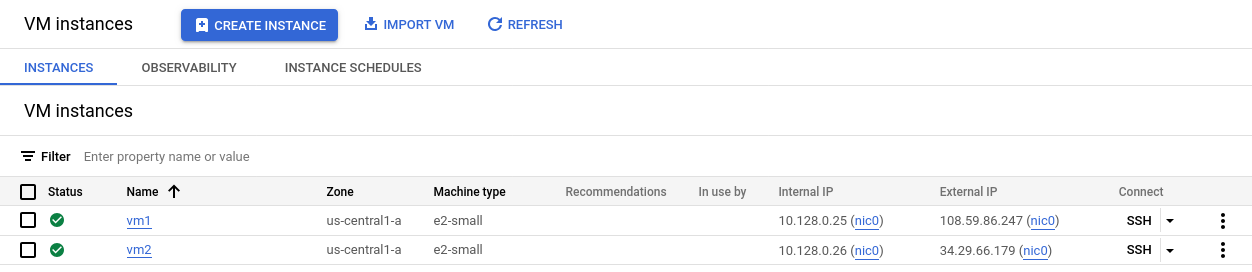

Now press the `SSH` button in the Connect column. After a while you will see a terminal with you logged to your VM! Now you can test if you see the second VM. Try to ping it using the internal IP. You can also use its name - it is configured as a hostname in the local network.

Try to ssh from vm1 to vm2. You will see a "Permission denied" error message. Same if you would try to ssh from your computer onto any of those VMs using their external IP. As you should remember from last week, ssh connection between nodes is necessary for MPI tasks to work, so let's now fix that!

### SSH keys setup


Upload your ssh public key (for how to generate one see this [tutorial](https://www.ssh.com/academy/ssh/keygen)). Don't forget to save inserted values.
```
Hamburger (☰) -> Compute Engine -> Metadata
Navigate to 'SSH KEYS' -> 'Edit' -> 'Add Item'
paste your ssh key (change the comment at the end of the key, to username you would like to have on the cluster)
save (bottom of the page)
```
**IMPORTANT NOTE: the username created on the machine depends on the comment value of the provided key. Changing comments of the keys to username you would like to have on the cluster will save you a lot of trouble. Using special characters and dots can cause some problems. If you want your key to work with in-browser ssh, set the comment to the same username as in there (it is derived from your email).**

Now try to ssh from your computer to the `vm1` using its public IP, to test if it worked. If your local username is different from the email in google cloud, you need to specify it when connecting, e.g., `ssh jan.kowalski@123.456.789` where 123.456.789 is your VM's IP address.

If so we can configure access between VMs. For this purpose we need to upload additional ssh public key. First, create a new pair of private-public key on `vm1` and add it to settings:

```
ssh-keygen -q -t ed25519 -C "$USER" -f ~/.ssh/id_pdd -N ""
echo "IdentityFile /home/$USER/.ssh/id_pdd" > ~/.ssh/config
cat ~/.ssh/id_pdd.pub
```

Paste the output as a new SSH key in the cloud. Now you should be able to ssh from `vm1` to `vm2`, but not the other way around. There are two ways to fix it:
- More work intensive: Generate another key pair on the `vm2` and add it to cloud metadata.
- Less secure: Copy the key pair from `vm1` to `vm2`:
```
scp ~/.ssh/id_pdd ~/.ssh/id_pdd.pub ~/.ssh/config vm2:~/.ssh/
```

If we would want to run an ML training on those VMs we would still need to install required software on each VM, upload the code, and distribute the data among workers. And all this separately for each VM we want to use for training. As you might imagine, this process quickly becomes tedious and error-prone as our needs and setup complexity grow. For this reason it is good practice to automate this process, and currently the most reliable way to do this is to use an Infrastructure as a Code tool. We will do this in the remainder of this lab scenario.

**IMPORTANT: we won't need the VMs you created anymore. You should delete them now to avoid loosing credits**

## Terraform and Ansible

[Terraform](https://www.terraform.io/) and [Ansible](https://www.ansible.com/) are tools based on the Infrastructure as a Code (IaC) principle. They allow us to automate the process of renting cloud resources (Terraform) and performing the setup and maintenance tasks on them (Ansible).
You can perform this setup on your personal computer or on the computer in the labs.

This setup is inspired by this [tutorial](https://roparst.gricad-pages.univ-grenoble-alpes.fr/cloud-tutorials/mpi/).

The Terraform and Google Cloud CLI are installed on the lab computers (but not on the students machine), so if you work from the lab, you need only to install Ansible in a virtual environment (`pip install ansible`). If you want to work from your computer, then you need also to install [Terraform](https://developer.hashicorp.com/terraform/install) and [Google Cloud CLI](https://cloud.google.com/sdk/docs/install).


### Setup
We start from generating the ssh key pair and sending it to the Google Cloud Metadata. Actually, we have already done that manually in the previous section, so you can skip those steps, but then remember to change the value of the `GCP_privateKeyFile` environment variable to the location of your private SSH key.

Note: change the value of gcp\_userID variable to your cloud username (your google login where . are replaced with _). Execute the following commands in the console.

In [ ]:
mkdir lml-lab2
cd lml-lab2

#Generate ssh key pair (NOTE: change the user ID to yours)
export GCP_userID="name_surname"  # your GCP_userID is your google login where . are replaced with _

mkdir .ssh
ssh-keygen -t ed25519 -f .ssh/id_gcp -N '' -C $GCP_userID

Now we will pass your public key to the Google Cloud Metadata.
Save and run the following script to generate a file that will allow Terraform to do it.

IMPORTANT: This method will remove all your existing metadata ssh keys. If you don't want to lose them, add the key manually in the [Google Cloud Console](https://console.cloud.google.com/compute/metadata) instead.

In [ ]:
#!/bin/bash
cat > transform_key.tf <<- EOM
resource "google_compute_project_metadata" "default" {
  metadata = {
    ssh-keys = <<EOF
EOM
echo -n "      $GCP_userID:" >> transform_key.tf
cat .ssh/id_gcp.pub >> transform_key.tf
cat >> transform_key.tf <<- EOM
    EOF
  }
}
EOM


Fill the values of the environment values in the script below:
  - PROJECT\_ID: You can find it in the home screen of the [Google Cloud Console](https://console.cloud.google.com/) - see the screenshot below.
  - GCP\_userID: is your google login where . are replaced with _ (you see it in the console).
  - GCP\_privateKeyFile: The path to the private ssh key, you have created in the previous step.

Copy the script below to the `setup.sh` file and run it: `. ./setup.sh`.

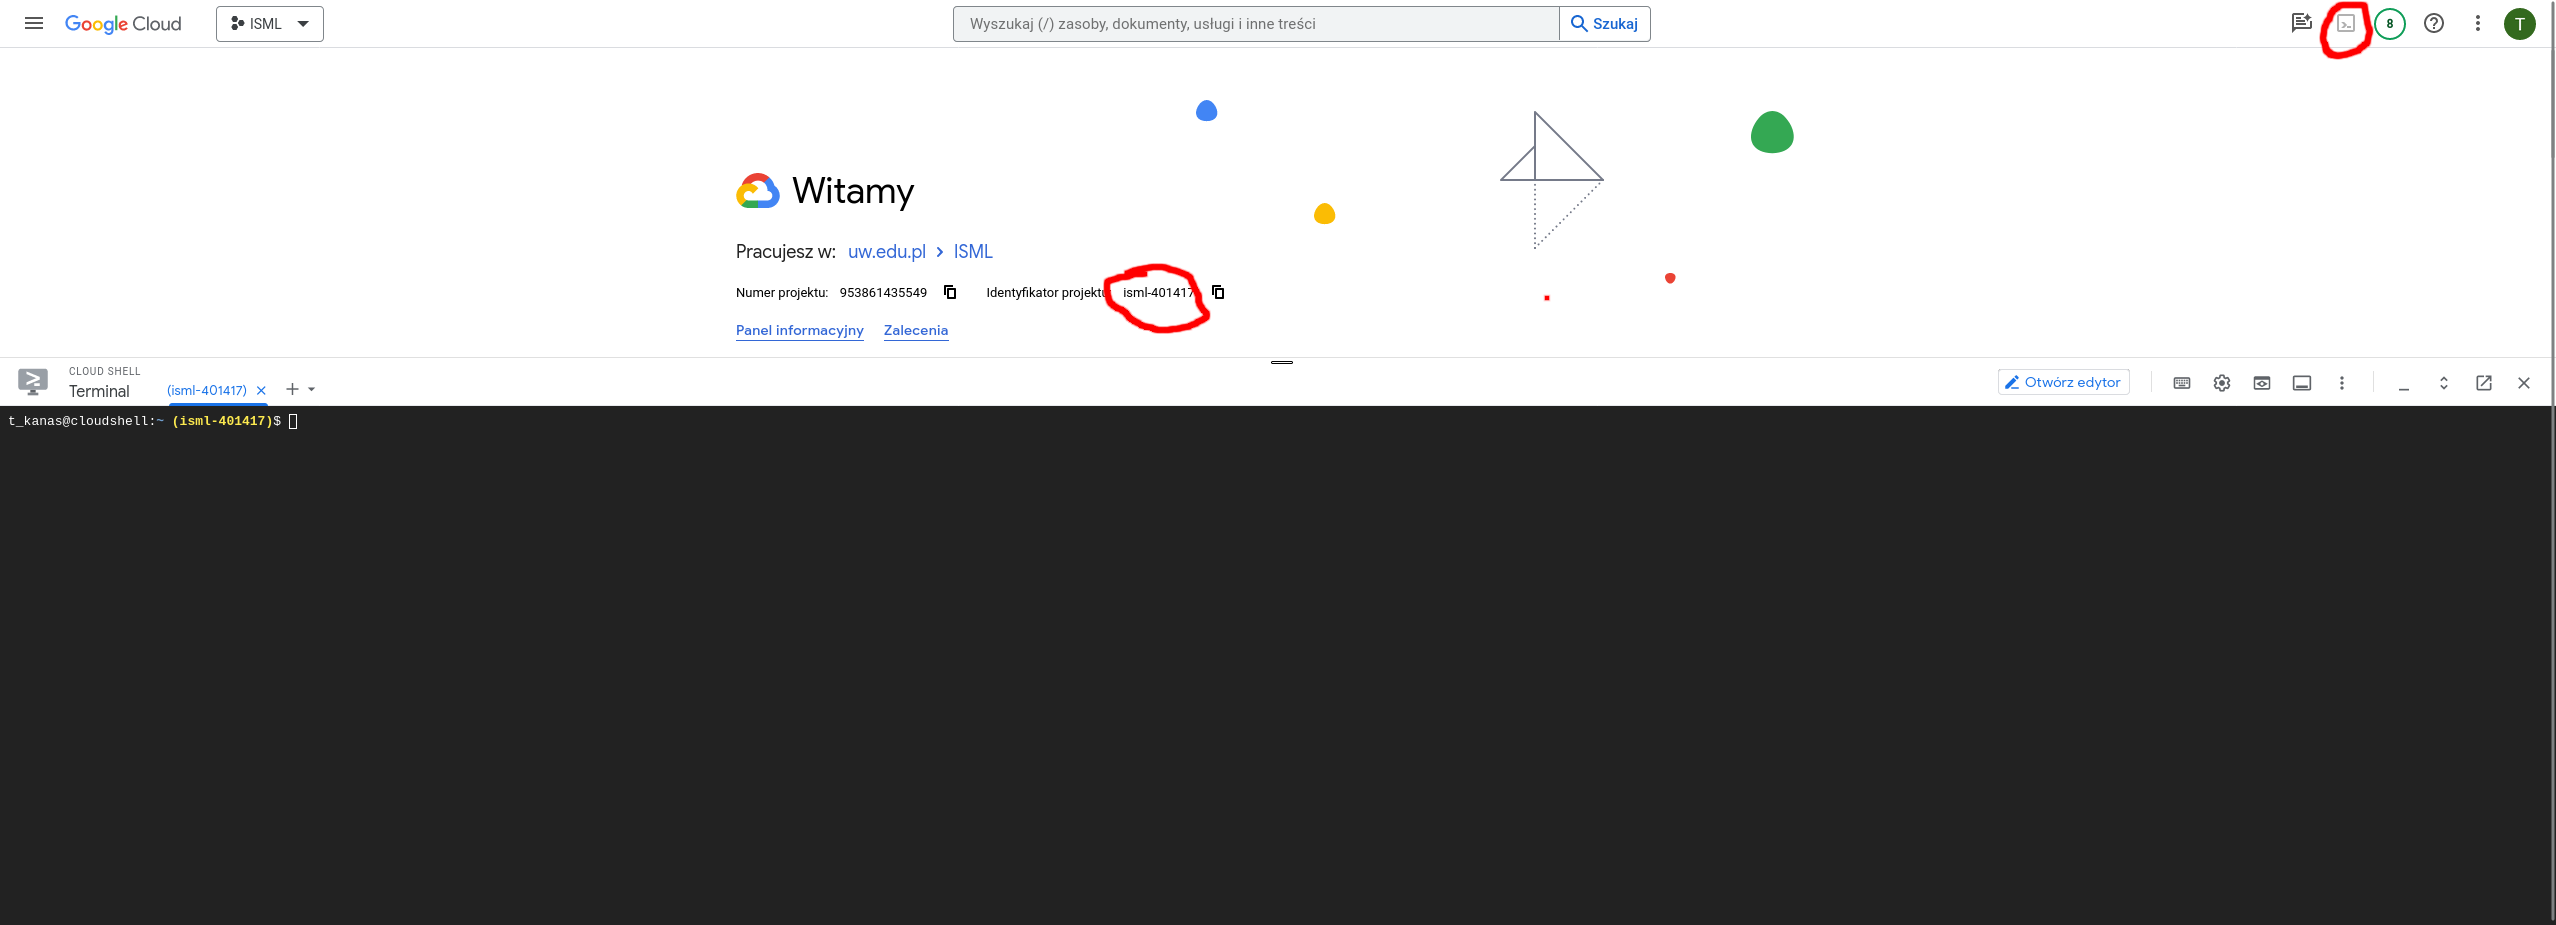

In [ ]:
#!/bin/bash
export PROJECT_ID="TODO"
export SERVICE_NAME="bml-lab"
export GCP_userID="TODO"
export GCP_privateKeyFile=".ssh/id_gcp"

### Terrform setup variables
export TF_VAR_project=$PROJECT_ID

To log in to the Google Cloud run commands:

```
gcloud auth login
gcloud init
```

`gcloud` is the command provided by the Google Cloud CLI package and it allows you to do everything (and even more) that you could do in the web interface of the GCP from console. It is also very handy, as most guides provide `gcloud` commands instead of instructions how to setup required thing in the web interface.

Note: in this scenario we will be using local terminal, but if in future you would prefer using the website, you can also use gcloud from the terminal included in the website (see the screenshot above).

### Setup the Identity and Access Management (IAM)

We now need to configure the authorization and authentication methods for us to use to manage our VMs. GCP has very complex system of IAM, that allows even the largest organizations to manage their access policies securely and safely.

The basic terms of IAM in GCP are:
- Identity: the actor that is performing an action. It may be user but also an automatic process.
- Role: a group of permissions that can be granted to identities.
- Resource: it may be a phisycal resource as a VM for example, but may also be an organization, folder or project used to organize sets of other resources.
- Policy: collection of role bindings that bind one or more principals to individual roles.

We need to create a new identity in the form of a *service account* (see the VM creation section). Then we need to grant it (create policy binding) a role of editor, so that it can be used to manage VMs. Finally we need to configure a way of authentication to this service account. For the ease of use sake we will use a service account key: this is just an RSA key pair that needs to be stored on a drive and used to access the service account. Note that this isn't the safest option provided by Google, so you might want to review the [best practices for managing service account keys](https://cloud.google.com/iam/docs/best-practices-for-managing-service-account-keys) or other [authentication methods](https://cloud.google.com/docs/authentication).

For more information about IAM in GCP we refer to the [documentation](https://cloud.google.com/iam/docs/overview).

To create new service account, policy binding and service account key run the commands:
```
gcloud iam service-accounts create $SERVICE_NAME
gcloud projects add-iam-policy-binding $PROJECT_ID --member serviceAccount:$SERVICE_NAME@$PROJECT_ID.iam.gserviceaccount.com --role roles/editor
gcloud iam service-accounts keys create ./$SERVICE_NAME.json --iam-account $SERVICE_NAME@$PROJECT_ID.iam.gserviceaccount.com
```

It will create the file `$SERVICE_NAME.json`, that will hold the service account key: keep it for further uses (otherwise you will have to repeat those steps).

### Terraform configuration

Now we are ready to write the Terraform module that will automate the process of requesting the resources for us. Terraform uses a simple declarative language in its modules. It means that we need to specify only what we want to get, and it is the Terraform problem how to get it.

Copy the following code and save it in a `simple_deployment.tf` file (the .tf is a usual Terraform extension).

```
variable "project" {
  type = string
}

provider "google" {
  credentials = file("bml-lab.json")
  project     = var.project
  region      = "us-central1"
  zone        = "us-central1-c"
}

resource "google_compute_instance" "vm_instance" {
  count        = 3
  name         = "bml-${count.index}"

  machine_type = "e2-medium"

  boot_disk {
    initialize_params {
      image = "debian-cloud/debian-11"
      size  = 20
    }
  }

  network_interface {
    # A default network is created for all GCP projects
    network       = "default"
    access_config {
    }
  }
}

// A variable for extracting the external ip of the first instance
output "ip" {
 value = "${google_compute_instance.vm_instance[0].network_interface.0.access_config.0.nat_ip}"
}
```

Let us make a quick overview of the contents of this file. Firstly we define a variable. Variables in terraform are parameters that can be passed by several methods and allow for customization of modules without altering their code. Here we use them to pass your project name without fixing it in the source code - we will pass it by an environment variable that we have already declared in `setup.sh`.

Next we pass the provider specific information: the service account key file for authentication, the project to create the VMs in, region and zone.

Finally we specify the resources we want to request: VMs in Google cloud. We also provide their count, names, machine types (we have chosen the smallest ones that can run pytorch), what disk image to use (we increased the size to 20 GB as 10 GB is not enough to fit Pytorch) and the network interface to setup.

At the end we also specify an output variable - this is the value that will be printed by terraform after provisioning the resources. For your convenience we will print the external IP of the first machine if you would need to SSH to it.

### Run Terraform

Finally we can run Terraform. Firstly we need to initialize it:

```
terraform init
```

Now we can test the configuration and generate the provisioning plan:

```
terraform plan
```

If you did everything well, terraform will print what it will do if you run it. Look at this plan, and make sure that it will create 3 VMs of `e2-medium` machine type. If everything looks fine, you can apply:

```
terraform apply
```

Check in the web UI that you see 3 newly created VMs.

Now verify that you can ssh to the IP that terraform printed. Remember to use the login that you used when adding the ssh key to the metadata:
```
ssh -i .ssh/id_gcp USER@IP.ADDR.HERE
```

### Install MPI and Pytorch using Ansible

Ansible is a software tool designed for cross-platform automation and orchestration at scale. It uses a YAML files named playbooks that contain one or more plays. A play defines a set of tasks to run on a specific host or a group of hosts.

All hosts and groups of hosts are defined in a single configuration file, that contains their IP adresses and may also contain other configuration variables.

We will use Ansible to install Pytorch as well as MPI on those machines. We will use MPI to execute distributed tasks, as using torchrun would require to run command on every node.

To create this configuration file, we will write a bash script that will extract the IPs from the `terraform.tfstate` file. This file is a JSON file created by terraform, that contains all the information about current deployment.

Copy the following script and save it in the `parse-tf-state.py` file on the same machine that you run terraform on. Then execute it.

In [ ]:
#!/usr/bin/env python3
import json
import sys
import os

IPs = []
hostnames = []


with open('terraform.tfstate') as json_file:
    data = json.load(json_file)
    for res in data['resources']:
        if res['name'] == 'vm_instance':
            for vm in res['instances']:
                hostnames.append(vm['attributes']['name'])
                for nic in vm['attributes']['network_interface']:
                    if nic['name'] == 'nic0':
                        print("{} (IP: {})".format(vm['attributes']['name'], nic['access_config'][0]['nat_ip']))
                        IPs.append(nic['access_config'][0]['nat_ip'])



with open('hosts', 'w') as host_file:
    host_file.write('[key_node]\n')
    host_file.write(IPs[0]+'\n')
    host_file.write('\n')

    host_file.write('[mpi_nodes]\n')
    for IP in IPs:
        host_file.write(IP+'\n')
    host_file.write('\n')

    host_file.write('[nfs_server]\n')
    host_file.write(IPs[0]+'\n')
    host_file.write('\n')

    host_file.write('[nfs_clients]\n')
    first = True
    for IP in IPs:
        if not first:
            host_file.write(IP+'\n')
        first = False
    host_file.write('\n')

    host_file.write('[all:vars]\n')
    host_file.write('ansible_ssh_user={}\n'.format(os.environ['GCP_userID']))
    host_file.write('ansible_ssh_private_key_file={}\n'.format(os.environ['GCP_privateKeyFile']))
    host_file.write('ansible_ssh_common_args=\'-o StrictHostKeyChecking=no\'\n')
    host_file.write('nfs_server={}\n'.format(hostnames[0]))

with open('hostfile_mpi', 'w') as mpi_file:
    for host in hostnames:
        mpi_file.write(host+'\n')


This script should have created two files: `hostfile-mpi` is just a hostfile to use with MPI, like last week. The `hosts` file is the configuration file for Ansible and should look similar to this:

```
[key_node]
34.135.55.161

[mpi_nodes]
34.135.55.161
34.29.177.129
34.171.254.174

[nfs_server]
34.135.55.161

[nfs_clients]
34.29.177.129
34.171.254.174

[all:vars]
ansible_ssh_user=YOUR_USERNAME
ansible_ssh_private_key_file=~/.ssh/id_ed25519
ansible_ssh_common_args='-o StrictHostKeyChecking=no'
nfs_server=bml-0
```

Here we define a `key_node` that will be the main node, `mpi_nodes` which is the group of all nodes, `nfs_server` which will be the main server of our NFS filesystem, and remaining nodes in the group `nfs_clients`. At the end there are also defined several variables.

Now we will install required software on all the VMs. Copy the following script and save it as `install_packages.yml`.

```
---
- hosts: mpi_nodes
  tasks:
  - name: install openmpi
    apt:
      name:
        - openmpi-bin
        - libopenmpi-dev
        - python3
        - python3-pip
      state: latest
      update_cache: true
    become: yes
    become_method: sudo

  - name: Install numpy and pytorch
    ansible.builtin.pip:
      name:
        - numpy
        - torch
```

As you see we firstly run task on all `mpi_nodes` to use `apt` with all the packages we want to install. Then we run pip to install numpy and pytorch. To execute this script, run the command (it may take several minutes):

```
ansible-playbook -i hosts install_packages.yml
```

Now we will configure the ssh keys, as we need to have paswordless connection between all VMs. Copy the following script and save it in the `config_ssh.yml` file.

```
---
- name: creating a new ssh key without password
  hosts: key_node
  tasks:
    - name: Generate ssh key pair
      openssh_keypair:
        path: /tmp/id_ssh_rsa

    - name: Fetch the public key from the node to master
      fetch:
        src: "/tmp/id_ssh_rsa.pub"
        dest: "buffer/id_rsa.pub"
        flat: yes

    - name: Fetch the private key from the node to master
      fetch:
        src: "/tmp/id_ssh_rsa"
        dest: "buffer/id_rsa"
        flat: yes
      
- name: configuring all the hosts
  hosts: mpi_nodes
  tasks:
    - name: Set authorized key
      authorized_key:
        user: "{{ ansible_ssh_user }}"
        state: present
        key: "{{ lookup('file', 'buffer/id_rsa.pub') }}"
        
    - name: Copy private key
      copy:
        src: "buffer/id_rsa"
        dest: ".ssh/id_rsa"
        mode: '0600'

    - name: Deactivate StrictHostKeyChecking
      shell:
        cmd: printf "Host * \n\t StrictHostKeyChecking no" > .ssh/config
        creates: .ssh/config

    - name: Copy machinefile
      copy:
        src: "hostfile_mpi"
        dest: "hostfile_mpi"
        mode: '0600'
```

In this script we create new key-value pair in the `key_node` and then distribute it among all VMs (the less safe option). We also add the public key to the authorized keys and copy the `hostfile_mpi` file to the hosts. Again, execute the script by running:

```
ansible-playbook -i hosts config_ssh.yml
```

Finally, for convenience we will install NFS (Network File System) on the VMs, so that we don't have send the code and data files to all the nodes.

Copy the following script and save it as `nfs.yml`:

```
---
- hosts: nfs_server
  become: yes
  tasks:
    - name: install nfs-kernel-server
      apt:
        name:
          - nfs-kernel-server
        state: latest
        update_cache: true
      become: yes
      become_method: sudo
    - name: Create a mountable directory if it does not exist
      file:
        path: /home/nfs
        state: directory
        owner: root
        group: root
        mode: '0775'
    - name: enable rpcbind nfs-server
      service:
        name: "{{ item }}"
        enabled: yes
      with_items:
        - rpcbind
        - nfs-server
    - name: Copy exports file.
      template:
        src: ./exports.j2
        dest: /etc/exports
        owner: root
        group: root
        mode: 0644
    - name: NFS apply change configrue
      shell: systemctl reload nfs;exportfs -a

- hosts: nfs_clients
  become: yes
  tasks:
    - name: install nfs-common
      apt:
        name:
          - nfs-common
        state: latest
        update_cache: true
      become: yes
      become_method: sudo
    - name: Create a mountable directory if it does not exist
      file:
        path: /home/{{ ansible_ssh_user }}
        state: directory
        owner: "{{ ansible_ssh_user }}"
        group: "{{ ansible_ssh_user }}"
        mode: '0775'
    - name: Ensure that nothing is currently mounted to target directory
      shell:
        cmd: umount /home/{{ ansible_ssh_user }}
      become: yes
      become_method: sudo
      ignore_errors: yes
    - name: Mount volume
      shell:
        cmd: mount {{ nfs_server }}:/home/{{ ansible_ssh_user }} /home/{{ ansible_ssh_user }}
      become: yes
      become_method: sudo
```

We need also a configuration file for the NFS server - a file that configures the privileges of users. Copy the following file and save it as `exports.j2`.

```
# /etc/exports: the access control list for filesystems which may be exported
#   to NFS clients.  See exports(5).
/home/{{ ansible_ssh_user }}           *(rw,sync,no_root_squash,no_subtree_check)
```

Finally execute command (task "Ensure that nothing is currently mounted to target directory" may fail, it is fine):

```
ansible-playbook -i hosts nfs.yml
```

## Test the installation

To test the installation we will use the example from the previous classes with the reduce operation. Save the code below in a `reduce.py` file.


In [ ]:
import os
import time
import torch
import torch.distributed as dist

WORLD_SIZE = int(os.environ['OMPI_COMM_WORLD_SIZE'])
RANK = int(os.environ['OMPI_COMM_WORLD_RANK'])
dist.init_process_group("gloo", rank=RANK, world_size=WORLD_SIZE)

message = torch.tensor(RANK)
print(f"Rank {RANK}: Sending {message.item()}")
dist.reduce(message, 0, dist.ReduceOp.SUM)

if RANK == 0:
  print(f"Rank 0: Sum of all messages is {message.item()}")

Now you can send it to one of your machines using `scp` and then invoke a `mpiexec` command remotely using `ssh`. Copy one of the VM IPs into the commands below and run them:

```
export GCP_IP=VM_ID
scp -i .ssh/id_gcp reduce.py $GCP_userID@$GCP_IP:~
ssh -i .ssh/id_gcp $GCP_userID@$GCP_IP "mpiexec --hostfile hostfile_mpi -x MASTER_ADDR=bml-0 -x MASTER_PORT=12340 -n 3 python3 reduce.py"
```

If it succeeded congratulations, you have finished this scenario!

# IMPORTANT: Remove created resources at the end of the session
```
terraform destroy
```

**And don't forget to enter 'yes'!**

We can easily recreate them now, so nothing is lost upon deletion!

# Frequently Asked Questions

If you receive the message "WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!" when trying to ssh (or scp) to one of your VMs it most likely means that you have recreated the VMs and then they have accidentaly received the same IP. Just remove the entries for their IPs from `~/.ssh/known_hosts` file.